In [ ]:
# Define paths here! the function is run at the bottom of the file, including variable definitions here so you don't have to scroll all the way down.

format_file = '/prvt/ilio/EZDisturbance/haze/cfk/calibcm_for_kennedi/spextraction_input_binned_lat.txt'
data_list = '/prvt/ilio/EZDisturbance/haze/cfk/calibcm_for_kennedi/data_list_test.txt'
map_save_location = '/prvt/ilio/EZDisturbance/haze/cfk/calibcm_for_kennedi/test_maps/'
specfile = './jupiter.spx'
solarfile = '/prvt/ilio/EZDisturbance/haze/cfk/calibcm_for_kennedi/kurucz_HST_IRTF.dat'

# defaults:
meancm_path='/prvt/ilio/EZDisturbance/haze/'
wavelength_keyword='OSF'
plot_maps=0
map_load=1
IF_scale=1
file_format='Nemesis'
IF_plot_save_location='./IF_plot.pdf'
    
# variable definitions
'''
format_file - string, path+name of input file for spectrum bin parameters. contains code for what kind of spectra to make. For now, only 1 format but will change that.
data_list - text file containing paths+names of images from which to extract spectra. Proabbly just want one image per wavelength and grouped together in time (up to the user how to do that). Will sort by wavelength here so no need to do that in the input file. Will assume that the list contains images of the same target. 
plot_maps - on/off switch, int. Will plot maps if 1, not if 0.
specfile - string, path+name of spectrum file to be made and saved. 
solarfile - file containing solar spectrum. 

# defaults:
meancm_path - string, path of location of meancm*.sav files. Default here is where Glenn has them saved. 
map_load - int, on/off switch. 0, will save maps to path defined by map_save_location. 1, will load maps from that location.
map_save_location - path to location of saved maps. 
IF_scale = int, 1 or 0. 1, will use python version of calibcm to scale the data to I/F, will automatically make an I/F plot and save it in IF_plot_save_location.
file_format - string, label for desired format of spectrum file. currently only coded for Nemesis spx files.
IF_plot_save_location - string, path+name of location to save I/F plots
'''

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.interpolate import interp1d
import math
from pylanetary.navigation import *
from pylanetary.utils import *
from uncertainties.umath import *
from uncertainties import unumpy
from uncertainties import ufloat
from scipy import interpolate
from datetime import datetime
from datetime import timedelta
from astroquery.jplhorizons import Horizons
import astropy.units as u
import math
from scipy import ndimage
from scipy import io

In [2]:
'''
The below functions will generate spectrum files to be used as input for a radiative transfer model. At the moment, the only avialable format is for NEMESIS, and much of the code is catered to IRTF SpeX Guidedog images. Should still be generally applicable and easy to add more options later. Individual functions have doc strings explaining inputs and outputs. To make spectra, run spectrum_file_maker() at the end of the notebook after compiling the other functions.

To run this code:
1. Install pylanetary into a new conda environment: https://github.com/emolter/pylanetary/tree/main
2. Install uncertainties package into that environment: 
    $ conda activate pylanetary-tester
    $ pip install uncertainties
3. Run this code within that conda environment (to implement it within a jupyter notebook, use https://medium.com/@nrk25693/how-to-add-your-conda-environment-to-your-jupyter-notebook-in-just-4-steps-abeab8b8d084)

Written by Emma Dahl and Kennedi White, 2023/2024

There are comments flagged with !! throughout that should go into a big to-do list, or that might become issues later.
Biggest oustanding issues:
-in spectral extraction, issue w/ mu going above 1. I don't think those spectra are equally spaced in mu
-Conversion to radiance/I/F, solar spectrum to use?
-Adding more options for implementing specta, probably a readme file for using those input files
-Eventually adding the ability to calculate azimuth and solar zenith angle to pylanetary; will make projposolar and its auxiliary code unnecessary
!! Implement spectral error that's made earlier on into spec_file_maker().
'''

"\nThe below functions will generate spectrum files to be used as input for a radiative transfer model. At the moment, the only avialable format is for NEMESIS, and much of the code is catered to IRTF SpeX Guidedog images. Should still be generally applicable and easy to add more options later. Individual functions have doc strings explaining inputs and outputs. To make spectra, run spectrum_file_maker() at the end of the notebook after compiling the other functions.\n\nTo run this code:\n1. Install pylanetary into a new conda environment: https://github.com/emolter/pylanetary/tree/main\n2. Install uncertainties package into that environment: \n    $ conda activate pylanetary-tester\n    $ pip install uncertainties\n3. Run this code within that conda environment (to implement it within a jupyter notebook, use https://medium.com/@nrk25693/how-to-add-your-conda-environment-to-your-jupyter-notebook-in-just-4-steps-abeab8b8d084)\n\nWritten by Emma Dahl and Kennedi White, 2023/2024\n\nThere

In [3]:
# functions used within map_maker() to generate maps.

def interceptellip(a,b,alpha,beta,gamma,x0,y0,z0):
    '''
    ; **********************************************************
    ; procedure to find the intercepts (if any) between the line
    ;
    ;  (x-x0)       (y-y0)      (z-z0)
    ;  ------  =    ------   =  ------
    ;  alpha         beta       gamma
    ; 
    ; and the ellipsoid
    ;
    ;
    ;  x^2    y^2    z^2   
    ;  --- +  --- +  ---  = 1
    ;  a^2    a^2    b^2
    ;
    ; Input variables
    ;       a       real    ellipsoid semi-major axis
    ;       b       real    ellipsoid semi-minor axis
    ;       alpha   real    line x-gradient
    ;       beta    real    line y-gradient
    ;       gamma   real    line z-gradient
    ;       x0      real    line x-intercept
    ;       y0      real    line y-intercept
    ;       z0      real    line z-intercept
    ;
    ; Output variables
    ;       iflag   integer Set to 1 if line intercepts, set to -1  otherwise
    ;       x(2)    real    x-intercepts
    ;       y(2)    real    y-intercepts
    ;       z(2)    real    z-intercepts
    ;
    ; Pat Irwin     11/2/07
    ; Python conversion - Emma Dahl 3-8-19
    ; **********************************************************
    '''
    a1 = 1.0/a**2 + (beta/(a*alpha))**2 + (gamma/(b*alpha))**2

    b1 = (-2*x0*beta**2/alpha**2 + 2*beta*y0/alpha)/a**2
    b1 = b1 + (-2*x0*gamma**2/alpha**2 + 2*gamma*z0/alpha)/b**2
    
    c1 = ((beta*x0/alpha)**2 - 2*beta*y0*x0/alpha + y0**2)/a**2
    c1 = c1 + ((gamma*x0/alpha)**2 - 2*gamma*x0*z0/alpha + z0**2)/b**2 -1
        
    #;print,a1,1.0/a**2 + (gamma/(b*alpha))**2
    #;print,b1,2*gamma*z0/(alpha*b**2)
    #;print,c1,(y0/a)**2 + (z0/b)**2 -1
    
    xtest = b1**2 - 4*a1*c1

    x = np.zeros(2)
    y = np.zeros(2)
    z = np.zeros(2)
        
    if xtest > 0.0:
        iflag = 1
        x[0] = (-b1 + np.sqrt(xtest))/(2*a1)
        x[1] = (-b1 - np.sqrt(xtest))/(2*a1)
        y[0] = y0 + (beta/alpha)*(x[0]-x0)
        y[1] = y0 + (beta/alpha)*(x[1]-x0)
        z[0] = z0 + (gamma/alpha)*(x[0]-x0)
        z[1] = z0 + (gamma/alpha)*(x[1]-x0)

        # testing to see if solution is on ellipsoid
        test=np.ndarray(len(x))
        for i in range(0,len(x)):
            test[i] = (x[i]/a)**2 + (y[i]/a)**2 + (z[i]/b)**2
        xtest1 = abs(test[0]-1.0)
        xtest2 = abs(test[1]-1.0)
        
        err = 1e-5
        
        if xtest1 > err or xtest2 > err:
            print('Problem in interceptellip - solution not on ellipsoid')
            print('Test =',test)
    else:
        iflag = -1


    return iflag,x,y,z

interceptellip_vec = np.vectorize(interceptellip)

def projposolar(Re,obl,epsilon,latsol,lonsol,se_lon,eoff,poff):
    '''
    ; ************************************************************
    ; Procedure to find latitude and longitude and zenith angle of
    ; intercept between line and ellipsoid
    ;
    ; Input variables
    ;       Re      real    Equatorial Radius (arcsec)
    ;       obl     real    Planetary oblateness
    ;       epsilon real    Sub-observer (planetocentric) latitude
    ;       latsol  real    Sub-solar planetocentric latitude
    ;       lonsol  real    longitude difference between sub-solar and sub-observer
    ;                       points.
    ;       se_lon  real    Sub-observer longitude # added by Emma
    ;       eoff    real    equatorial offset of beam (arcsec)
    ;       poff    real    polar offset of beam (arcsec)
    ;
    ; Output variables
    ;       iflag   integer Set to 1 if real intercept, -1 otherwise
    ;       xlat    real    Planetocentric latitude
    ;       longitude real  xlon+se_lon, offset of longitude added to sub-observer longitude # added by Emma
    ;       xlon    real    Longitude
    ;       zen     real    Zenith angle
    ;       szen    real    Solar zenith angle
    ;       aphi    real    local azimuth angle between sun and observer
    ;
    ; Pat Irwin     11/2/07
    ; Python conversion - Emma Dahl 3/8/19
    ; ************************************************************
    '''
    
    dtr = np.pi/180.0 # radians/degrees
    Rp = Re*(1.0-obl)
    
    x0 = 0.0
    y0 = eoff
    z0 = poff/np.cos(epsilon*dtr)
    
    alpha = np.sin(np.pi/2.0 - epsilon*dtr)
    beta = 0.0
    gamma = np.cos(np.pi/2.0 - epsilon*dtr)
    
    # commenting out to give program my own iflag map
    iflag,x,y,z = interceptellip_vec(Re,Rp,alpha,beta,gamma,x0,y0,z0)
    #print(iflag)
    
    xlat = 0.0
    xlon = 0.0
    zen = 0.0
    
    # !!! getting rid of iflag statement here because I already have the maps set up for real intercepts below
    #if iflag > 0:
    # if real intercept, find lat, long, and zenith

    # find distance along line of sight
    lambdaa = (x-x0)/alpha
    if lambdaa[0] > lambdaa[1]:
        inear = 0
    else:
        inear = 1

    x1 = x[inear]
    y1 = y[inear]
    z1 = z[inear]

    r = np.sqrt(x1**2 + y1**2 + z1**2)

    theta = np.arccos(z1/r)
    xlat = 90.0 - theta/dtr

    #; convert to planetographic latitude
    #; xlat = np.arctan(((Re/Rp)**2)*np.tan(xlat*dtr))/dtr

    cphi = x1/(r*np.sin(theta))

    if cphi > 1.0:
        cphi = 1.0
    if cphi < -1.0:
        cphi = -1.0

    phi = np.arccos(cphi)
    if y1 < 0.0:
        phi = -phi
    xlon = phi/dtr        

    # Finding aphi, zen, szen - don't mess with these, want to still output them

    v1 = np.zeros(3)
    v2 = np.zeros(3)
    v3 = np.zeros(3)

    # v1 is normal vector of point observed
    v1[0] = x1/r
    v1[1] = y1/r
    v1[2] = z1/r

    v2[0] = alpha
    v2[1] = beta
    v2[2] = gamma

    summ = 0.0

    for i in range(0,3):
        summ += v1[i]*v2[i]
    zen = np.arccos(summ)/dtr

    # Finding aphi

    alphasol = np.sin(np.pi/2.0 - latsol*dtr)*np.cos(lonsol*dtr)
    betasol =  np.sin(np.pi/2.0 - latsol*dtr)*np.sin(lonsol*dtr)
    gammasol = np.cos(np.pi/2 - latsol*dtr)
    v3[0]=alphasol
    v3[1]=betasol
    v3[2]=gammasol

    summ = 0.0
    for i in range(0,3):
        summ += v1[i]*v3[i]
    szen = np.arccos(summ)/dtr

    cphase = 0.0

    for i in range(0,3):
        cphase += v2[i]*v3[i]

    a = np.cos(zen*dtr)*np.cos(szen*dtr)
    b = np.sin(zen*dtr)*np.sin(szen*dtr)

    if b == 0.0:
        aphi = 180.0
    else:
        cphi = (cphase-a)/b
        aphi = 180.0-np.arccos(cphi)/dtr
            
    longitude = se_lon-xlon # offset of longitude added to sub-observer longitude
    # Remember that system III longitude increases to the west
    
    #return xlat,longitude
    return iflag,xlat,longitude,xlon,zen,szen,aphi
    #return xlat,longitude,xlon,zen,szen,aphi

projposolar_vec = np.vectorize(projposolar)

In [4]:
def distance_finder(filename, ut_date='DATE_OBS', ut_time='TIME_OBS', target_name='Jupiter', location_code='568'):
    '''
    Queries horizons and produces distance in AU. Just copied relevant content from map_maker().
    
    Input:
    filename - string, path+name of fits file to map.    
    
    optional keyword arguments; defaults are those used by IRTF SpeX Guidedog camera
    ut_date - string, the header keyword for UT date of the observation
    ut_time - string, the header keyword for the average UT time of the observation
    target_name - string, planet being observed. so far just the gas giants are included. Adding more will require including more of the planets and their corresponding Horizons codes in the planets variable.
    location_code - string, horizons code of observing location. default = 568, Mauna Kea 
    
    output:
    distance to planet in AU
    '''
    planets = ('599','Jupiter',71492,66854,0.06487),('699','Saturn',60268,54364,0.09796),('799','Uranus',25559,24973,0.0229),('899','Neptune',24766,24342,0.0171)
    
    # import image
    im = fits.open(filename)
    header = im[0].header

    # based on UT time/date and location of observations, query Horizons for viewing geom info
    UT_date = header[ut_date]; UT_time = header[ut_time]; target = target_name
    
    # Account for fractional seconds in UT_time if it exists. datetime does not like fractional seconds.
    if '.' in UT_time:
        nofrag, frag = UT_time.split('.')
        UT_time = nofrag    

    # Query horizons. !! The date/time format for UT_date and UT_time as used in date_obj are specific to the format used by the IRTF.
    for k in planets: # find planet code, r_eq, r_pol, obl
        if k[1] == target: # assumes target string is exactly correct.
            id_number = k[0]; planet_label = k[1]; req = k[2]; rpol = k[3]; obl = k[4]

    # calculate julian date
    date_obj = datetime.strptime(UT_date+' '+UT_time, '%Y-%m-%d %H:%M:%S') # define datetime object based on UT date and time. Might have issue bc seconds are fractional
    date_only_obj = datetime.strptime(UT_date, '%Y-%m-%d')
    h = int(date_obj.strftime("%H")); m = int(date_obj.strftime("%M")); s = int(date_obj.strftime("%S"))
    dt = timedelta(hours=h, minutes=m, seconds=s)
    secs_per_day = 24*60*60    # hours * mins * secs
    jd_time_fraction = dt.total_seconds()/secs_per_day # fraction of day time, to add to date

    jd = date_only_obj.toordinal() + 1721424.5 + jd_time_fraction # based on https://stackoverflow.com/questions/13943062/extract-day-of-year-and-julian-day-from-a-string-date

    # put ephimerides into a table
    table = Horizons(id=id_number, location=location_code, epochs=jd).ephemerides()
    distance_au = table['delta'][0]
    
    return distance_au

In [7]:
def map_maker(filename, plot_maps=0,  ut_date='DATE_OBS', ut_time='TIME_OBS', target_name='Jupiter', location_code='568', pixelscale=0.115696):
    
    '''
    Program to generate viewing geometry maps. Will first query Horizons for 
    
    Inputs
    -----------
    filename - string, path+name of fits file to map.
    plot_maps - 0 or 1, int. on/off switch for plotting diagnostic plots. 0 = no plots, 1 = plots.
    
    optional keyword arguments; defaults are those used by IRTF SpeX Guidedog camera
    ut_date - string, the header keyword for UT date of the observation
    ut_time - string, the header keyword for the average UT time of the observation
    target - string, planet being observed. so far just the gas giants are included. Adding more will require including more of the planets and their corresponding Horizons codes in the planets variable.
    location_code - string, horizons code of observing location. default = 568, Mauna Kea
    pixelscale - float, pixel scale of instrument in "/pix. Default is guidedog on IRTF SpeX
    
    Outputs
    -----------
    iflag - 2D array, map of planet location. 1 where planet is, -1 where planet is not. !! save my self-made iflag map?
    latitude_final - 2D array, float, planetocentric latitude. nans everywhere else
    longitude_final - 2D array, float, sys III longitude (increases to west). nans everywhere else
    xlon - 2D array, longitude offset from meridian. nans everywhere else
    zen - 2D array of zenith emission angle. nans everywhere else
    szen - 2D array of soalr emission angle. nans everywhere else
    aphi - 2D array of azimuth angle. nans everywhere else
    data - 2D array of cropped, rotated, and aligned data. nans everywhere else
    ob_lon - sub-observer longitude (lcm in later functions)
    distance_au - distance to Jupiter in AU from the Earth (needed for spectrum file)
    '''
    
    print('Loading image info and querying Horizons...')
    
    #tuples of planets and their Horizons codes. Only gas giants for now, can add terrestrial planets. Horizons code, name, equatorial radius (km), polar radius (km), oblateness. would be nice to be able to pull radii from horizons eventually
    planets = ('599','Jupiter',71492,66854,0.06487),('699','Saturn',60268,54364,0.09796),('799','Uranus',25559,24973,0.0229),('899','Neptune',24766,24342,0.0171)
    
    # import image
    im = fits.open(filename)
    header = im[0].header
    data = im[0].data
    if plot_maps == 1:
        plt.imshow(data,origin='lower')
        plt.title('original data')
        plt.show()


    # based on UT time/date and location of observations, query Horizons for viewing geom info
    UT_date = header[ut_date] 
    UT_time = header[ut_time]
    target = target_name
    #target = header[target_keyword] # !! would like to make this query the header, but might generate some issues if target names aren't recorded the same across different datasets. 

    # Account for fractional seconds in UT_time if it exists. datetime does not like fractional seconds.
    if '.' in UT_time:
        nofrag, frag = UT_time.split('.')
        UT_time = nofrag    

    # Query horizons. !! The date/time format for UT_date and UT_time as used in date_obj are specific to the format used by the IRTF.

    for k in planets: # find planet code, r_eq, r_pol, obl
        if k[1] == target: # assumes target string is exactly correct. might be an issue if there are additional spaces
            id_number = k[0]; planet_label = k[1]; req = k[2]; rpol = k[3]; obl = k[4]

    # calculate julian date
    date_obj = datetime.strptime(UT_date+' '+UT_time, '%Y-%m-%d %H:%M:%S') # define datetime object based on UT date and time. Might have issue bc seconds are fractional
    date_only_obj = datetime.strptime(UT_date, '%Y-%m-%d')
    h = int(date_obj.strftime("%H"))
    m = int(date_obj.strftime("%M"))
    s = int(date_obj.strftime("%S"))
    dt = timedelta(hours=h, minutes=m, seconds=s)
    secs_per_day = 24*60*60    # hours * mins * secs
    jd_time_fraction = dt.total_seconds()/secs_per_day # fraction of day time, to add to date

    jd = date_only_obj.toordinal() + 1721424.5 + jd_time_fraction # based on https://stackoverflow.com/questions/13943062/extract-day-of-year-and-julian-day-from-a-string-date

    # define horizons query
    obj = Horizons(id=id_number, location=location_code, epochs=jd)

    # put ephimerides into a table
    table = obj.ephemerides()
    distance_au = table['delta'][0]
    distance = table['delta'][0]*1.496E8 # in AU, convert to km

    # define values needed for ModelEllopsoid
    ob_lon = table['PDObsLon'][0] #sub-observer longitude, degrees
    ob_lat = table['PDObsLat'][0] #sub-observer latitude, degrees, planetocentric
    sol_lon = table['PDSunLon'][0] #sub-solar longitude, degrees
    sol_lat = table['PDSunLat'][0] #sub-solar latitude, degrees, planetocentric
    pixscale_km = np.arctan(pixelscale*(1/206265))*distance
    np_ang = table['NPole_ang'][0] #degrees 

    # save values of values needed for projposolar, outside of eoff and poff. gratiutous but I'm tired
    Re = (req/pixscale_km)*pixelscale # equatorial radius in arcsec
    epsilon = ob_lat # Sub-observer (planetographic) latitude
    latsol = sol_lat # Sub-solar planetocentric latitude
    lonsol = sol_lon-ob_lon # longitude difference between sub-solar and sub-observer points

    # define offset and rotation values to be used for both data and iflag map rotation
    # !! hard coded planet center value keywords for IRTF
    cx = im[0].header['cx']; cy = im[0].header['cy']
    # x and y center of image
    x1 = im[0].header['naxis1']/2; y1 = im[0].header['naxis2']/2
    x_offset = int(cx-x1); y_offset = int(cy-y1)
    rot_ang = np.copy(np_ang)

    # - - - - - - - - - - - - - - - - - - - - - - 
    # begin generating iflag map using nav, rotate and crop

    # use pylanetary to generate map of where planet is and isn't, Might not need all lines here but keeping anyways to make sure nothing breaks
    
    obs_time = UT_date + ' ' + UT_time
    ellipsoid = ModelEllipsoid(ob_lon, ob_lat, pixscale_km, np_ang, req, rpol)
    body = Body(target, epoch=obs_time, location=location_code) 
    model = ModelBody(body, pixelscale, shape=(len(data),len(data[0])))
    nav = Nav(data, body, pixelscale)    

    # use nav.mu to make iflag map. rotated_mu_map will ultimately become iflag_map
    rotated_mu_map = np.copy(nav.mu)
    rotated_mu_map[np.where(np.isnan(rotated_mu_map)==True)] = 0 # make nans 0 so ndimage doesn't freak out.
    # rotate
    rotated_mu_map = ndimage.rotate(rotated_mu_map,rot_ang)

    # crop; ! might want to just use the same crop values for both data and iflag centeirng?
    if len(rotated_mu_map) > header['naxis1'] or len(rotated_mu_map[0]) > header['naxis2']:
        x_crop = int((len(rotated_mu_map)-header['naxis1'])/2)
        y_crop = int((len(rotated_mu_map[0])-header['naxis2'])/2)
        rotated_mu_map = rotated_mu_map[x_crop:-x_crop,y_crop:-y_crop]
        
    
    # - - - - - - - - - - - - - - - - - - - - - - 
    # rotate and crop data after it's been used to orient the iflag map
    # rotate and center image 
    data=np.roll(data,-y_offset,axis=0)
    data=np.roll(data,-x_offset,axis=1)

    data = ndimage.rotate(data,np_ang)

    # crop centered and rotated data
    if len(data) > header['naxis1'] or len(data[0]) > header['naxis2']:
        x_crop = int((len(data)-header['naxis1'])/2)
        y_crop = int((len(data[0])-header['naxis2'])/2)
        data = data[x_crop:-x_crop,y_crop:-y_crop]
    np_ang_orig = np.copy(np_ang)
    # update rotation angle and offset since data has been rotated and aligned
    np_ang = 0
    x_offset = 0; y_offset = 0

    if plot_maps == 1:
        plt.imshow(data,origin='lower')
        plt.title('centered rotated and cropped data')
        plt.show()
        
    # make sure iflag map and data have the same dimensions (otherwise will have issues mapping arrays later)
    if len(data) != len(rotated_mu_map) or len(data[0]) != len(rotated_mu_map[0]):
        print('! size of iflag map and data are not equal !')
        print('len(data):',len(data),'rotated_mu_map:',len(rotated_mu_map))
        print('len(data[0]):',len(data[0]),'rotated_mu_map[0]:',len(rotated_mu_map[0]))
        # if wrong numbers but ~1 pixel off, it's probably fine (if we're looking at Jupiter with plenty of pixels to spare)

    # use the rotated mu map to finish making iflag_map.
    # since using nd image rotate on 0's, very close to 0, rounding down. !!! very janky, likely a more elegant way to do this. 
    iflag_map = np.copy(rotated_mu_map)
    iflag_map = np.round(iflag_map,1)
    iflag_map[np.where(iflag_map==0)] = 0
    iflag_map[np.where(iflag_map!=0)] = 1

    # - - - - - - - - - - - - - - - - - - - - -
    # find eoff and poff, equatorial and polar offset needed for projposolar. Much of this is originally from working with tricky rotation so mostly unnecessart now, but leaving in in case we want to implement it later.

    # finding center point based on data array (should be same as x1 and y1 earlier?)
    x_center = len(data)/2
    y_center = len(data[0])/2

    # don't need but might be helpful for testing
    unrot_x = np.where(iflag_map==1)[0]
    unrot_y = np.where(iflag_map==1)[1]

    # list of coordinates where the planet is. Shifted to have origin at middle of image/planet
    x = unrot_x-x_center
    y = unrot_y-y_center

    np_ang_radians = np_ang*0.0174533 # rad/deg # in case still need to rotate. should be 0 if data already rotated

    # flipped these bc lat and long maps where backwards
    eoff = -x*np.sin(np_ang_radians)+y*np.cos(np_ang_radians)
    poff = x*np.cos(np_ang_radians)+y*np.sin(np_ang_radians)
    
    # translate the pixel offsets to arcsec offsets    
    eoff*=pixelscale 
    poff*=pixelscale

    # map eoff and poff values onto planet pixel locations using iflag
    eoff_final = np.copy(iflag_map)
    poff_final = np.copy(iflag_map)

    eoff_final[np.where(iflag_map==1)] = eoff
    poff_final[np.where(iflag_map==1)] = poff

    eoff_final[np.where(iflag_map!=1)] = np.nan
    poff_final[np.where(iflag_map!=1)] = np.nan

    if plot_maps == 1: # commented out bc not really necessary. Helpful for assessing issues though
        plt.imshow(eoff_final,origin='lower')
        plt.title('equatorial offset in arcsec')
        plt.colorbar()
        plt.show()
        plt.imshow(poff_final,origin='lower')
        plt.colorbar()
        plt.title('polar offset in arcsec')
        plt.show()

    # run projposolar, usng iflag map to find location of planet pixels
    print('Generating maps...(ignore following errors, they are accounted for w/ iflag map)')

    # will get mad if passed nans
    # generate maps of all the following values:
    iflag,latitude_final,longitude_final,xlon,zen,szen,aphi = projposolar_vec(Re,obl,epsilon,latsol,lonsol,ob_lon,eoff_final,poff_final)

    # flip maps along vertical axis (probably more elegant way to do this)
    szen=np.flip(szen,axis=1)
    aphi=np.flip(aphi,axis=1)
    
    if plot_maps == 1:
        plt.imshow(iflag,origin='lower')
        plt.colorbar(label='iflag')
        plt.show()
        
        plt.imshow(latitude_final,origin='lower')
        plt.colorbar(label='Latitude')
        plt.show()
        
        plt.imshow(longitude_final,origin='lower')
        plt.colorbar(label='Longitude (Sys III)')
        plt.show()
        
        plt.imshow(zen,origin='lower')
        plt.colorbar(label='Zenith emission angle')
        plt.show()
        
        plt.imshow(szen,origin='lower')
        plt.colorbar(label='Solar zenith angle')
        plt.show()
        
        plt.imshow(aphi,origin='lower')
        plt.colorbar(label='Azimuth angle')
        plt.show()

    return iflag,latitude_final,longitude_final,xlon,zen,szen,aphi,data,ob_lon

In [8]:
# test:
# flag,latitude_final,longitude_final,xlon,zen,szen,aphi,data,lcm = map_maker('/Users/emmadahl/Desktop/spextraction/test_data/jupiter/jcf01170125.gz.fits',plot_maps=1)

In [10]:
def spex_wavelengths(filename):
    '''
    Routine to find the correct wavelength for a SpeX Guidedog image given certain OS filter and G filter combos.
    wavelength: midpoint originally from table at http://irtfweb.ifa.hawaii.edu/~spex/work/filters/filters.html (but link seems to be broken now)
    
    input
    -filename: string, path+name of fits file to read. presumption is that this is a guidedog image.
    
    output
    -Wavelength float. mircons
    will return error if no matching wavelength is found
    '''
    wavelength = -1
    
    im = fits.open(filename)
    header = im[0].header
    osfilt = header['OSF']
    gfilt = header['GFLT']
    
    if gfilt == 'Open':
        # define list of tuples
        wavelength_tuple = (('Open',0.00),('Blank',0.00),('PK-50',2.5), ('Opt',2.5),  ('0.1',0.1), ('Long4',5.2), ('Long5',3.86), ('Long6',3.33), ('Short3',2.22), ('Short4',1.63), ('Short5',1.27), ('Short6',1.15), ('Short7',.95), ('CH4_l' ,1.69), ('CH4_s',1.58))
        for j in wavelength_tuple:
            if j[0] == osfilt:
                wavelength = j[1]
                return wavelength
        
    elif gfilt == 'H' and osfilt == 'CH4_s':
        wavelength = 1.58
        return wavelength
    # special case added to what was originally in idl program
    elif gfilt == 'J' and osfilt == 'CH4_s':
        wavelength = 1.58
        return wavelength
    elif gfilt == 'H' and osfilt == 'CH4_l':
        wavelength = 1.69
        return wavelength
        
    else:
        # define list of tuples
        wavelength_tuple = (('Open',0.00), ('Blank',0.00), ('Z',1.00),('J',1.215), ('H',1.654), ('K',2.23), ("L'",3.80), ('Lp',3.80), ("M'",4.76) ,('FeII',1.64), ('H2',2.12), ('Bry',2.16), ('contK',2.26), ('CO',2.29), ("M'+ND1",4.76), ('3.417',3.417), ('3.454',3.454), ('5.1',5.100))
        for j in wavelength_tuple:
            if j[0] == gfilt:
                wavelength = j[1]
                return wavelength
        
    if wavelength == -1:
        print('Error! No matching wavelength found for filter combo by spex_wavelengths()')
        return

In [11]:
def map_saver(dictionary,key,map_save_location,wl):
    '''
    just saves the map of mapvalue (e.g. aphi, zen, etc.) to a file. Making this a routine to avoid copying the same 3 lines over and over    

    dictionary - wavelength dictionary of map dictionaries
    key - string, label of map, will be used as key to pull that array
    map_save_location - string, path of location to save maps
    wl - wavelength of dictionary of dictionaries
    '''
    wl = str(wl)
    wl_dict = dictionary[wl]
    np.savetxt(map_save_location+key+'_'+str(wl),wl_dict[key+'_'+str(wl)])

In [12]:
# python version of congrid, an idl routine

def calibcm(data, iflag, lat, wavelength, meancm_path='/prvt/ilio/EZDisturbance/haze/'):
    '''
    Finding I/F scaling factors for each wavelength. adapted from Glenn's calibcm*.pro programs
    this requires that tou have the meancm* data for each wavelength. I've copied them here and renamed them to correspond directly to the wavelength instead of filter name
    !! Need to double check that this is scaling things correctly. Glenn said it does it by latitude, is this code doing that correctly? I thought I translated his code correctly but should double-check. 
    !! want to add plot of brightnesses on same scale.
    !! Add a routine here that looks at all available meancm*.sav files in meancm_path, and then ignores wavelengths that aren't there and reports them with an error message. Probably right at beginning.
    
    data - 2D array, data.
    iflag - 2D iflag map. 
    lat - lat map
    mu - 2D array, mu map. don't need, glenn uses it to find the CM of the image
    wavelength - float, wavelength in microns of that file. used to find the right meancm file (right now only able to do 1.58, 1.64, 1.69, 2.12, 2.16, 2.26) 
    meancm_path - string, path to location of .sav files. default is their location at JPL.
    '''
    wavelstr = str(wavelength)
    
    meancm_name= 'meancm'+wavelstr[0]+wavelstr[-2:]+'.sav'
    meancm = io.readsav(meancm_path+meancm_name)
    calibstdcm = meancm['meancm']
    
    # !! need to plot these on the same scale. 
    #plt.plot(calibstdcm[10:170])
    #plt.ylabel('I/F')
    #plt.show()
    
    # take the sum of the mean cm values within -80 to +80 deg
    calibstd = np.sum(calibstdcm[10:170])
    
    # pull cm of image. simpler than glenn's version bc its already centered
    xcen = int(len(data)/2)
    ycen = int(len(data[xcen])/2)

    cmscan = data[:,xcen] # pulling 3 columns around center bc the python version of congrid FREAKS otherwise
    # crop off nans
    #cmscan = cmscan[np.where(iflag[:,int(len(data)/2)] != -1)]
    cmscan = cmscan[np.where((lat[:,int(len(data)/2)] > -80)&(lat[:,int(len(data)/2)] < +80))]
    
    #plt.plot(cmscan)
    #plt.ylabel('Raw pixel values')
    #plt.show()
    
    # take the sum between 80 and 80 deg lat
    cmtotal = np.sum(cmscan)
    
    newscale = calibstd/cmtotal # scale factor to be applied to data
    
    
    return newscale

In [ ]:
# test calibcm. Need to save data, iflag, and lat from map_maker() first.
#calibcm(data, iflag, latitude_final, 1.58, meancm_path='/Users/emmadahl/Desktop/spextraction/meancm/')

In [ ]:
# Add error_finder() here. Run it within spextraction_images and return another array w/ error for each average spectrum. maybe after I/F scaling?

In [13]:
def spextraction_images(format_file, data_list, map_save_location, wavelength_keyword='OSF', plot_maps=0, map_load=0, IF_scale=0, meancm_path='/prvt/ilio/EZDisturbance/haze/', alternate_error_region=0):
    # !!! change map_save_location
    '''    
    Extract spectra based on user input, using maps generated by map_maker(). This version is for extracting spectra from images. Maybe make other versions later?
    Added calibcm() for dps. only takes 6 wavelengths at the moment.
    
    --------------------
    Input:
    format_file - string, path+name of input file. contains code for what kind of spectra to make (1=equal mu bins within a given latitude/longitude bin). For now, only 1 format but will change that.
    data_list - input file containing paths+names of images to extract spectra from. Proabbly just want one image per wavelength and grouped together in time (up to the user how to do that). Will sort by wavelength here so no need to do that in the input file. Will assume that the list contains images of the same target. 
    plot_maps - on/off switch, int. Will plot maps
    
    saving/loading things: take advantage of this! otherwise takes a while to make maps new every time.
    !! bug: change map load/save to a single variable to avoid a user having both map_save=1 and load_maps=1 which will break.
    map_load - int, on/off switch. 0, will save maps to path defined by map_save_location. 1, will load maps from that location.
    map_save_location - path to location of saved maps. 
    IF_scale = int, 1 or 0. 1, will use python version of calibcm to scale the data to I/F
    meancm_path - string, path to location of .sav files. default is their location at JPL.
    alternate_error_region - int, 0 or 1. if the default region selected to estimate error doesn't work (e.g., a moon in the way), set to 1 and use a region on the other side of the planet.

    
    output:
    arrays for each image/wavelength
    error_estimate - assumed to be the square of the variance of the background. potentially a better way to do this.
    
    # !! lots of comments with !! need attention. didn't bother to write htem here as to-do items
    but lcm is acting real weird. since we're doing meridian
    # !! error_estimate is hard-coded to a region of the image to find the stdev.
    '''
    
    datalist = np.loadtxt(data_list,dtype=str) # load list of images
    guidedog_wavelengths = () # list of tuples that correspond to the filters used and corresponding wavelengths. OSF, GFLT, and then WL # !! might not use this
    
    # sort images by wavelength
    wl = []
    image = []
    if wavelength_keyword == 'OSF': # if spex guidedog images
        for j in datalist:
            wl.append(spex_wavelengths(j))
            image.append(j)
    else:
        for j in datalist:
            im = fits.open(j)
            wl.append(im[0].header[wavelength_keyword])
            image.append(j)
    # sort images based on wavelength
    wl_sorted_images = [x for _,x in sorted(zip(wl,image))]
    wavelengths_sorted = sorted(wl)
    
    print(wavelengths_sorted)
    
    # open input file and determine type of spectrum to make
    with open(format_file,'r') as f:
        all_data=[x.split() for x in f.readlines()]
        spec_type = int(all_data[0][0]) # find and define
        if spec_type == 1:
            # if mu-binned lat spectrum, find other requirements:
            lat_min = float(all_data[1][0])
            lat_max = float(all_data[1][1])
            mu_min = float(all_data[2][0])
            n_bins = int(all_data[3][0])
            meridian_switch = float(all_data[4][0])
            w_mu = float(all_data[5][0])
            
        elif spec_type == 2:
            # if different kind of spectrum, do something else. Fill this in later.
            return
        
    n_bins = 2
            
    
    # - - - - - - - - - - - Map saving/loading
    
    # make maps for each image/wavelength. Is there a way to write this avoid making new maps every time? save them somewhere with the obs_time in the file name, and we can check to see if it's been saved somewhere already.
    map_dict = {}
    for i in range(0,len(wl_sorted_images)):
        print('Arranging map info for',str(wavelengths_sorted[i]))
        if map_load == 1: # load maps
            map_dict_dummy = {}
            # load each map for that wavelength and save it to the dictionary
            iflag = np.loadtxt(map_save_location+'iflag_'+str(wavelengths_sorted[i]))
            latitude_final = np.loadtxt(map_save_location+'latitude_final_'+str(wavelengths_sorted[i]))
            longitude_final = np.loadtxt(map_save_location+'longitude_final_'+str(wavelengths_sorted[i]))
            zen = np.loadtxt(map_save_location+'zen_'+str(wavelengths_sorted[i]))
            szen = np.loadtxt(map_save_location+'szen_'+str(wavelengths_sorted[i]))
            aphi = np.loadtxt(map_save_location+'aphi_'+str(wavelengths_sorted[i]))
            mu = np.loadtxt(map_save_location+'mu_'+str(wavelengths_sorted[i]))
            data = np.loadtxt(map_save_location+'data_'+str(wavelengths_sorted[i]))
            lcm = np.loadtxt(map_save_location+'lcm_'+str(wavelengths_sorted[i]))
            
            map_dict_dummy['iflag_'+str(wavelengths_sorted[i])] = iflag
            map_dict_dummy['latitude_final_'+str(wavelengths_sorted[i])] = latitude_final
            map_dict_dummy['longitude_final_'+str(wavelengths_sorted[i])] = longitude_final 
            map_dict_dummy['zen_'+str(wavelengths_sorted[i])] = zen 
            map_dict_dummy['szen_'+str(wavelengths_sorted[i])] = szen
            map_dict_dummy['aphi_'+str(wavelengths_sorted[i])] = aphi
            map_dict_dummy['mu_'+str(wavelengths_sorted[i])] = mu
            map_dict_dummy['data_'+str(wavelengths_sorted[i])] = data
            map_dict_dummy['lcm_'+str(wavelengths_sorted[i])] = lcm
            map_dict[str(wavelengths_sorted[i])] = map_dict_dummy
            
        elif map_load == 0: # otherwise, make a dictionary of maps for that wavelength to save them to
            map_dict_dummy = {}
            iflag,latitude_final,longitude_final,xlon,zen,szen,aphi,data,lcm = map_maker(wl_sorted_images[i],plot_maps)
                        
            map_dict_dummy['iflag_'+str(wavelengths_sorted[i])] = iflag
            map_dict_dummy['latitude_final_'+str(wavelengths_sorted[i])] = latitude_final
            map_dict_dummy['longitude_final_'+str(wavelengths_sorted[i])] = longitude_final 
            map_dict_dummy['zen_'+str(wavelengths_sorted[i])] = zen 
            map_dict_dummy['szen_'+str(wavelengths_sorted[i])] = szen
            map_dict_dummy['aphi_'+str(wavelengths_sorted[i])] = aphi
            map_dict_dummy['mu_'+str(wavelengths_sorted[i])] = np.cos(zen*0.0174533)
            map_dict_dummy['data_'+str(wavelengths_sorted[i])] = data
            # code is getting mad that lcm isn't an array. i'm tired so here is the bad fix
            lcm_array = np.copy(data)
            lcm_array[:,:] = lcm
            map_dict_dummy['lcm_'+str(wavelengths_sorted[i])] = lcm_array
            map_dict[str(wavelengths_sorted[i])] = map_dict_dummy            
            
            print('Saving maps at '+str(wavelengths_sorted[i])+'...')
            map_saver(map_dict,'iflag',map_save_location,wavelengths_sorted[i])
            map_saver(map_dict,'latitude_final',map_save_location,wavelengths_sorted[i])
            map_saver(map_dict,'longitude_final',map_save_location,wavelengths_sorted[i])
            map_saver(map_dict,'zen',map_save_location,wavelengths_sorted[i])
            map_saver(map_dict,'szen',map_save_location,wavelengths_sorted[i])
            map_saver(map_dict,'aphi',map_save_location,wavelengths_sorted[i])
            map_saver(map_dict,'mu',map_save_location,wavelengths_sorted[i])
            map_saver(map_dict,'data',map_save_location,wavelengths_sorted[i])
            map_saver(map_dict,'lcm',map_save_location,wavelengths_sorted[i])
            # if normal file.write() stuff works in map_saver: map_saver(iflag,map_save_location,wavelengths_sorted[i])
    
    # - - - - - - - - - - - - - - - - - - - - - 
    # # find mu_max from an example map. Does this need to be done at each wavelength? probably fine.
    wl_dummy = wavelengths_sorted[0]
    mu_map = map_dict[str(wl_dummy)]['mu_'+str(wl_dummy)]
    lat_map = map_dict[str(wl_dummy)]['latitude_final_'+str(wl_dummy)]
    data_map = map_dict[str(wl_dummy)]['data_'+str(wl_dummy)]
    lcm_map = map_dict[str(wl_dummy)]['lcm_'+str(wl_dummy)] # added for DPS, need this for defining the side of the meridian

    coordinates = np.where((lat_map<lat_max) & (lat_map>lat_min)) 

    mu_max = np.max(mu_map[coordinates])
    mu_max = 1.0
    
    if plot_maps == 1:
        new=np.copy(mu_map); new2=np.copy(mu_map); data_test = np.copy(data_map); data_test2 = np.copy(data_map)

        new[coordinates] = 5000
        new_coordinates = np.where(new<5000) 

        data_test[coordinates] = np.nan # blank out data we're sampling
        data_test2[new_coordinates] = np.nan # show only data we're sampling. Looks smaller but don't worry, will be fine

        print('Region of spectral extraction:')
        plt.imshow(new,origin='lower')
        plt.show()
        plt.imshow(data_test,origin='lower')
        plt.show()
        plt.imshow(data_test2,origin='lower')
        plt.show()
        plt.imshow(mu_map,origin='lower')
        plt.colorbar()
        plt.show()
        
    # - - - - - - - - - - - - - - - - - - - - -
    
    # based on inputs above, extract spectra from maps
    
    n_wavel = len(wavelengths_sorted) # number of wavelengths
    wavel_spxs = np.copy(wavelengths_sorted) # just copying this instead of renaming bc lazy

    # define bins based on n_mu (number of bins) and other info calculated earlier
    if spec_type == 1:
        d_mu = ((mu_max-mu_min)/n_bins) # size of mu bin
        print('Size of mu bin:',d_mu)
        
    #elif spec_type == 2:
    #    continue # add other spectral types here

    # define bins w/ the size of bin (d_mu) in mu-space. not relevant yet
    #d_mu = 0.1 # example, if defining by size of bin
    
    '''
    For defining bins w/ size of mu bin and not number of bins
    mu_max = 1.0
    w_mu = 0.1
    n_mu = int((mu_max-mu_min)/d_mu)
    n_bins = n_mu*2+1
    '''
    n_bins = 2
    
    # utilize dictionaries to save spectra and corresponding geometry values for each wavelength.
    
    # make empty arrays for binning section. columns = bins, rows = wavelengths
    extracted_spectrum_ave = np.zeros((n_bins,n_wavel))
    extracted_lat_ave = np.zeros((n_bins,n_wavel))
    extracted_long_ave = np.zeros((n_bins,n_wavel))
    extracted_emiss_ave = np.zeros((n_bins,n_wavel))
    extracted_solar_ave = np.zeros((n_bins,n_wavel))
    extracted_azi_ave = np.zeros((n_bins,n_wavel))
    error_estimate = np.zeros((1,n_wavel))
    

    for i_wavel in range(0,len(wavel_spxs)):
        
        print('Extracting spectra for',wavel_spxs[i_wavel],'microns...')
        
        # pull maps for this wavelength
        # !!! just raw data here for spxs. make sure to convert to physical units later
        spxs = map_dict[str(wavel_spxs[i_wavel])]['data_'+str(wavel_spxs[i_wavel])]
        mu_spxs = map_dict[str(wavel_spxs[i_wavel])]['mu_'+str(wavel_spxs[i_wavel])]
        lat_spxs = map_dict[str(wavel_spxs[i_wavel])]['latitude_final_'+str(wavel_spxs[i_wavel])]
        long_spxs = map_dict[str(wavel_spxs[i_wavel])]['longitude_final_'+str(wavel_spxs[i_wavel])]
        solar_spxs = map_dict[str(wavel_spxs[i_wavel])]['szen_'+str(wavel_spxs[i_wavel])]
        zen_spxs = map_dict[str(wavel_spxs[i_wavel])]['zen_'+str(wavel_spxs[i_wavel])]
        azimuth_spxs = map_dict[str(wavel_spxs[i_wavel])]['aphi_'+str(wavel_spxs[i_wavel])]
        lcm_spxs = map_dict[str(wavel_spxs[i_wavel])]['lcm_'+str(wavel_spxs[i_wavel])] 
        iflag_spxs = map_dict[str(wavel_spxs[i_wavel])]['iflag_'+str(wavel_spxs[i_wavel])] 

        # once lists are loaded, extract spectra
        wavel = wavel_spxs[i_wavel]        
        
        # test error before scaling
        # Error estimate:
        # find max extent of planet in aligned map; pull a rectangle above that region. Dimensions of this rectangle are hard-coded !!! and arbitrary based on a test image.
        # units of extracted error value will account for IF_scale being turned on or off. 
        max_iflag_y = np.max(np.where(iflag_spxs==1)[0]); max_iflag_x = np.max(np.where(iflag_spxs==1)[1])
        min_iflag_y = np.min(np.where(iflag_spxs==1)[0]); min_iflag_x = np.min(np.where(iflag_spxs==1)[1])

        if alternate_error_region == 1:
            # if error region doesn't look good, use upper right
            error_estimate[0,i_wavel] = np.std(spxs[(max_iflag_x-20):max_iflag_x, (max_iflag_y-20):max_iflag_y])
            if plot_maps == 1:
                plt.imshow(spxs[(max_iflag_x-20):max_iflag_x, (max_iflag_y-20):max_iflag_y],origin='lower')
                print('Error estimate:',error_estimate[0,i_wavel])
                plt.colorbar()
                plt.title('Error region')
                plt.show()
            
        else:
            # otherwise, use lower left
            error_estimate[0,i_wavel] = np.std(spxs[min_iflag_x:(min_iflag_x+20), min_iflag_y:(min_iflag_y+20)
])
            if plot_maps == 1:
                plt.imshow(spxs[min_iflag_x:(min_iflag_x+20), min_iflag_y:(min_iflag_y+20)],origin='lower')
                print('Error estimate:',error_estimate[0,i_wavel])
                plt.colorbar()
                plt.title('Error region')
                plt.show()
                
        
        if IF_scale == 1:
            # scale to I/F
            newscale = calibcm(spxs,iflag_spxs,lat_spxs,wavel,meancm_path) # !! assuming default meancm_path.
            print('scaling factor for I/F:',newscale)
            spxs *= newscale
            error_estimate[0,i_wavel] = newscale*(error_estimate[0,i_wavel]**2)
            plt.imshow(spxs,origin='lower')
            plt.colorbar()
            plt.show()
            
        else:
            error_estimate[0,i_wavel] = error_estimate[0,i_wavel]**2
        
        
        # h = 0 # bin index, for assigning values in arrays. might need if meridian_switch = 0
        
        # for DPS:
        mu = [(0.5,0.625),(0.875,1.0)]
        
        for i_mu in range(0,n_bins):
            # calculate mu boundaries
            # !! this is giving mu values above 1 which don't exist
            #mu_0 = mu_min + float(d_mu*i_mu)
            #mu_1 = mu_min + float(d_mu*i_mu) + w_mu
            
            
            mu_0 = mu[i_mu][0]
            mu_1 = mu[i_mu][1]
            print('mu_0=',mu_0,'mu_1=',mu_1)
            
            
            
            if meridian_switch == 1: # if averaging bins on either side of meridian

                #coords = np.where((lat_map<lat_max) & (lat_map>lat_min) & (mu_map>mu_0) & (mu_map<mu_1))
                coords = np.where((lat_spxs<lat_max) & (lat_spxs>lat_min) & (mu_spxs>mu_0) & (mu_spxs<mu_1) & (long_spxs > lcm_spxs[0][0])) # adding lcm_spx for the west side of the meridian only
                # !!!! in the line above, need to replace *_map with the *_spxs. be sure to change in actual program and not just dps program
                if plot_maps == 1:
                    spxs_test = np.copy(spxs)
                    spxs_test[coords] = np.nan
                    plt.imshow(spxs_test,origin='lower')
                    plt.title('extraction region for bin '+str(i_mu))
                    plt.show()
                    
                # save average of the regions within coords to extracted_* arrays
                extracted_spectrum_ave[i_mu,i_wavel] = np.mean(spxs[coords])
                extracted_lat_ave[i_mu,i_wavel] = np.mean(lat_spxs[coords])
                extracted_long_ave[i_mu,i_wavel] = np.mean(long_spxs[coords])
                extracted_emiss_ave[i_mu,i_wavel] = np.mean(zen_spxs[coords])
                extracted_solar_ave[i_mu,i_wavel] = np.mean(solar_spxs[coords])
                extracted_azi_ave[i_mu,i_wavel] = np.mean(azimuth_spxs[coords])
                
            elif meridian_switch == 0:
                print('Emma hasnt coded this yet, do not use')
                # here's where lcm would be used. eg as condition for either side of lcm
                return 
 
    # add distance-finding routine here. make array w number of bins to assign distances to
    # !!!! update mu_max to stay below 1.
    
    return extracted_spectrum_ave, extracted_lat_ave, extracted_long_ave, extracted_emiss_ave, extracted_solar_ave, extracted_azi_ave, wavelengths_sorted, n_bins, error_estimate

In [14]:
# example test
#extracted_spectrum_ave, extracted_lat_ave, extracted_long_ave, extracted_emiss_ave, extracted_solar_ave, extracted_azi_ave, wavelengths_sorted, n_bins, error_estimate = spextraction_images('/Users/emmadahl/Desktop/spextraction/spextraction_input_binned_lat.txt', '/Users/emmadahl/Desktop/spextraction/data_list_test.txt', '/Users/emmadahl/Desktop/spextraction/test_maps_2/', map_load=1, plot_maps=0, IF_scale=0, meancm_path='/Users/emmadahl/Desktop/spextraction/meancm/')

In [15]:
# example test - used for debugging
#extracted_spectrum_ave, extracted_lat_ave, extracted_long_ave, extracted_emiss_ave, extracted_solar_ave, extracted_azi_ave, wavelengths_sorted, n_bins, error_estimate = spextraction_images('/Users/emmadahl/Desktop/spextraction/spextraction_input_binned_lat.txt',\
#'/Users/emmadahl/Desktop/spextraction/irtf_data_march_2019/2019jun1/input_list', \
#'/Users/emmadahl/Desktop/spextraction/test_maps/', \
#map_load=1, plot_maps=1, IF_scale=0, meancm_path='/Users/emmadahl/Desktop/spextraction/meancm/',alternate_error_region=0)

In [16]:
# optional: run this and following cells to make plots of I/F spectra

# example test
#extracted_spectrum_ave, extracted_lat_ave, extracted_long_ave, extracted_emiss_ave, extracted_solar_ave, extracted_azi_ave, wavelengths_sorted, n_bins, error_estimate = spextraction_images('/Users/emmadahl/Desktop/spextraction/spextraction_input_binned_lat.txt', '/Users/emmadahl/Desktop/spextraction/irtf_data_march_2019/2019jun1/input_list', '/Users/emmadahl/Desktop/spextraction/test_maps_dps/', map_load=1, plot_maps=1, IF_scale=1)


In [22]:
def IF_plotter(wavelengths_sorted,extracted_spectrum_ave,error_estimate,IF_plot_save_location, error_10_percent=0):
    
    '''
    plot the I/F spectra, assuming there's 2 of them. Assumes things have already been converted to I/F
    
    wavelengths_sorted - list of wavelengths from spextraction_images
    extracted_spectrum_ave - array of average extracted spectra
    IF_plot_save_location - string, path+name of location to save pdf image. Make sure filename ends in .pdf
    error_10_percent - int, 1 - will assume 10% error; 0, will use error estimate
    ''' 
    


    fig, ax = plt.subplots(dpi=200)
    fig.set_size_inches(6, 3) # set size

    plt.plot(wavelengths_sorted,extracted_spectrum_ave[1],'.-',color='red',label=r'$\mu$=0.875-1.0 (close to nadir)')
    plt.plot(wavelengths_sorted,extracted_spectrum_ave[0],'.-',color='blue',label=r'$\mu$=0.5-0.625 (closer to limb)')
    
    if error_10_percent == 1:
        plt.fill_between(wavelengths_sorted,\
            extracted_spectrum_ave[1]+0.1*extracted_spectrum_ave[1],\
            extracted_spectrum_ave[1]-0.1*extracted_spectrum_ave[1],color='red',alpha=0.2)
        plt.fill_between(wavelengths_sorted,\
            extracted_spectrum_ave[0]-0.1*extracted_spectrum_ave[0],\
            extracted_spectrum_ave[0]+0.1*extracted_spectrum_ave[0],color='blue',alpha=0.2)


    plt.fill_between(wavelengths_sorted,\
                     extracted_spectrum_ave[1]+error_estimate[0],\
                     extracted_spectrum_ave[1]-error_estimate[0],color='red',alpha=0.2)
    plt.fill_between(wavelengths_sorted,\
                     extracted_spectrum_ave[0]-error_estimate[0],\
                     extracted_spectrum_ave[0]+error_estimate[0],color='blue',alpha=0.2)

    plt.ylabel('I/F')
    plt.xlabel('Wavelength (microns)')
    plt.legend()
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.0)
    
    # save a file containing the I/F spectra !! specific to 2 spectra
    file = open('./IF_spectrum','w')
    file.write('Saved automatically by Spextraction; contains I/F spectra \n')
    
    if error_10_percent == 1:
        file.write('# Wavelength (microns) | I/F, nadir | I/F, limb  | % error \n') # this header is specific to this setup w/ 2 spectra
        for j in range(0,len(wavelengths_sorted)):
            file.write(str(wavelengths_sorted[j])+' '+str(extracted_spectrum_ave[1][j])+' '+str(extracted_spectrum_ave[0][j])+' '+str(error_estimate[0][j])+' \n')
        file.close()
        
    else:
        file.write('# Wavelength (microns) | I/F, nadir | I/F, limb  | error estimate from bg \n') # this header is specific to this setup w/ 2 spectra
        for j in range(0,len(wavelengths_sorted)):
            file.write(str(wavelengths_sorted[j])+' '+str(extracted_spectrum_ave[1][j])+' '+str(extracted_spectrum_ave[0][j])+' '+str(error_estimate[0][j])+' \n')
        file.close()

    plt.savefig(IF_plot_save_location, format='pdf')

In [23]:
# !! this needs to be a subroutine for spextraction, instead of using it here

def spectrum_file_maker(format_file, data_list, map_save_location, specfile, solarfile, meancm_path='/prvt/ilio/EZDisturbance/haze/', wavelength_keyword='OSF', plot_maps=0, map_load=0, IF_scale=0, file_format='Nemesis',IF_plot_save_location='./IF_plot.pdf', error_10_percent=1):
    '''
    Makes a NEMESIS spx file of extracted spectra. saves I/F spectra to a figure
    
    # !! need to make it so that text is saved to a file.
    # !! need to generate solar spectrum file, or add routine here. there are spex-smoothed spectra in raddata but don't cover our wavelengths.
    # !! need to figure out physical unit situation. how to convert to I/F or radiance???
    # !! need an estimate of spectral error. its made earlier but here we assume 10%
    
    format_file - string, path+name of input file for spectrum bin parameters. contains code for what kind of spectra to make. For now, only 1 format but will change that.
    data_list - input file containing paths+names of images from which to extract spectra. Proabbly just want one image per wavelength and grouped together in time (up to the user how to do that). Will sort by wavelength here so no need to do that in the input file. Will assume that the list contains images of the same target. 
    plot_maps - on/off switch, int. Will plot maps if 1, not if 0.
    specfile - string, path+name of spectrum file to be made and saved. 
    solarfile - file containing solar spectrum. !! need to generate this for guidedog
    meancm_path - string, path of location of meancm*.sav files. Default here is where Glenn has them saved.
    
    map_load - int, on/off switch. 0, will save maps to path defined by map_save_location. 1, will load maps from that location.
    map_save_location - path to location of saved maps. 
    IF_scale = int, 1 or 0. 1, will use python version of calibcm to scale the data to I/F, will automatically make an I/F plot and save it in IF_plot_save_location.
    file_format - string, label for desired format of spectrum file. currently only coded for Nemesis spx files.
    IF_plot_save_location - string, path+name of location to save I/F plots
    error_10_percent - int, 1 - will assume 10% error and apply that to spx file and I/F plot
    '''
    
    # pull spectra using spextraction_images
    extracted_spectrum_ave, extracted_lat_ave, extracted_long_ave, extracted_emiss_ave, extracted_solar_ave, extracted_azi_ave, wavelengths, n_bins, error_estimate = \
    spextraction_images(format_file, data_list, map_save_location, wavelength_keyword=wavelength_keyword, map_load=map_load, plot_maps=plot_maps, IF_scale=IF_scale, meancm_path=meancm_path)
    
    if IF_scale == 1:
        # save I/F plots
        IF_plotter(wavelengths,extracted_spectrum_ave,error_estimate,IF_plot_save_location,error_10_percent)
    
    # !!!! finds the distance for a single image. Fine assumption as long as time between images isn't huge
    distance_file = np.loadtxt(data_list,dtype=str)[0]
    r = distance_finder(distance_file)
    if file_format == 'Nemesis':
        print('For .set file: distance between Sun and planet is '+str(round(r,4))+' AU')

    # can probably delete if its being read in. 
    n_bins = 2
    
    # - - - - - - - - - - -
    
    if file_format == 'Nemesis':
    
        #r = distance_finder() # AU. Might need this to find radiance in loop later
        
        # add loading of solar file here. Needs to be included as auxiliary file, and same file as in runname.sol
        F_sol = np.loadtxt(solarfile) # wavelength, solar radiance/luminosity
        # interpolate at our data points. Ideally this will also be convolved with our filter functions
        solar_func = interp1d(F_sol[:,0],F_sol[:,1])
        F_solar = []
        for g in wavelengths:
            F_solar.append(solar_func(g))
        print(F_solar)
        
        wavel_spxs = np.copy(wavelengths)
        
        FWHM = 0
        LATITUDE = np.mean(extracted_lat_ave) # the average latitude of all spectra in the file
        LONGITUDE = np.mean(extracted_long_ave) # the average longitude of all spectra in the file
        NGEOM = np.copy(n_bins)
        NAV = 1
        
        file = open(specfile,'w')
        # make top header
        file.write('     '+str(FWHM)+'  '+str(np.round(LATITUDE,3))+'  '+str(np.round(LONGITUDE,3))+'  '+str(NGEOM )+' \n')

        # for spectra headers
        NCONV = len(wavelengths)
        NAV = 1

        for p in range(0,n_bins):
            
            spec = np.copy(extracted_spectrum_ave)
            
            # define header for that mu bin
            FLAT = np.mean(extracted_lat_ave[p,:])
            FLON = np.mean(extracted_long_ave[p,:])
            SOL_ANG = np.mean(extracted_solar_ave[p,:])
            EMISS_ANG = np.mean(extracted_emiss_ave[p,:])
            AZI_ANG = np.mean(extracted_azi_ave[p,:])
            WGEOM = '1'

            file.write('     '+str(NCONV)+' \n')
            file.write('     '+str(NAV)+' \n')
            file.write('     '+str(np.round(FLAT,3))+'  '+str(np.round(FLON,3))+'  '+str(np.round(SOL_ANG,3))+'  '+str(np.round(EMISS_ANG,3))+'  '+str(np.round(AZI_ANG,3))+'  '+str(WGEOM)+' \n')

            # print spectrum
            for j in range(0,len(wavelengths)):
                # raw spectrum value*OPAL correction*IF factor*radiance conversion
                F_Sol_value = ufloat(F_solar[j],F_solar[j]*0.01) # assuming 1% error on solar spectrum

                # !!! stand-in unit conversion, should double-check.
                #spectrum_value_with_error = ufloat(spec[p][j],0.05*spec[p][j])*1e-7*(1/0.0001)*((F_solar[0]*1e-22)/(r**2)/math.pi/1000) #1e-22 from difference between thullier solar spec files

                # with error estimate: 
                if IF_scale == 1:
                    # if already converted to I/F:
                    if error_10_percent == 1:
                        # if assume 10% error:
                        spectrum_value_with_error = ufloat(spec[p][j],0.1*spec[p][j])*1e-7*(1/0.0001)*((F_solar[0]*1e-22)/(r**2)/math.pi/1000) #1e-22 from difference between thullier solar spec files
                    else:
                    # otherwise, use error_estimate. Found that that was too small when using background variance to estimate.
                        spectrum_value_with_error = ufloat(spec[p][j],error_estimate[0,j])*1e-7*(1/0.0001)*((F_solar[0]*1e-22)/(r**2)/math.pi/1000) #1e-22 from difference between thullier solar spec files
                elif IF_factor == 0:
                    # convert to I/F first if not done already.
                    print('Not programmed yet to calculate I/F within spectrum_file_maker()!')
                    

                # print wavelength in microns, radiance, error:
                file.write('     '+str(round(wavel_spxs[j],4))+'  '+ str(round(spectrum_value_with_error.nominal_value,12))+'  '+str(round(spectrum_value_with_error.std_dev,12))+' \n')

                # plot radiance spectra:
                #plt.plot(wavel_spxs[j],spectrum_value_with_error.nominal_value,'.')
            #plt.show()
        file.close()

In [ ]:
# Run spectrum_file_maker to generate spx files. Change variable names at top of file:

spectrum_file_maker(format_file, data_list, map_save_location, specfile, solarfile, meancm_path, wavelength_keyword, plot_maps, map_load, IF_scale, file_format,IF_plot_save_location)


[1.58, 1.64, 2.12, 2.16, 2.26]
Arranging map info for 1.58
Arranging map info for 1.64
Arranging map info for 2.12
Arranging map info for 2.16
Arranging map info for 2.26
Region of spectral extraction:


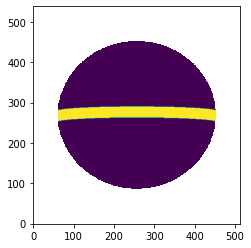

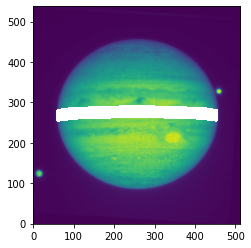

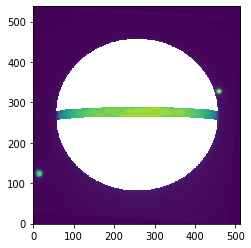

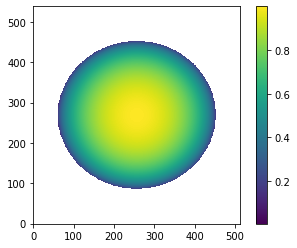

Size of mu bin: 0.25
Extracting spectra for 1.58 microns...
Error estimate: 9.562602563868849


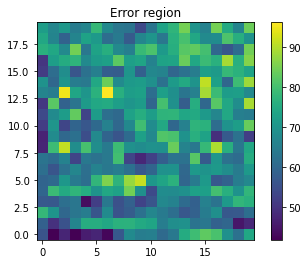

scaling factor for I/F: 3.3264926919918335e-05


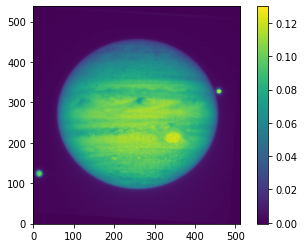

mu_0= 0.5 mu_1= 0.625


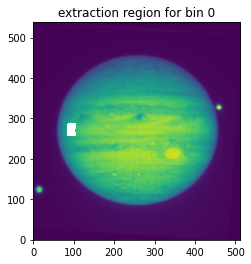

mu_0= 0.875 mu_1= 1.0


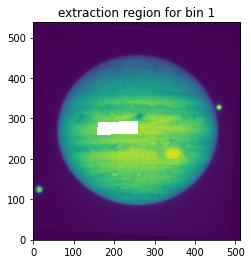

Extracting spectra for 1.64 microns...
Error estimate: 16.76555307463866


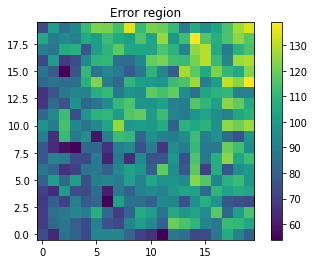

scaling factor for I/F: 1.1827159034138013e-06


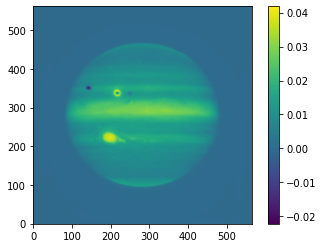

mu_0= 0.5 mu_1= 0.625


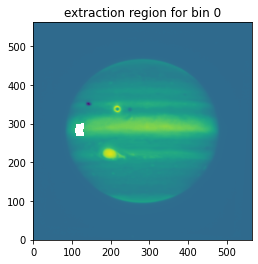

mu_0= 0.875 mu_1= 1.0


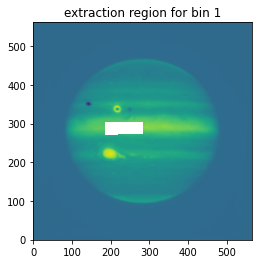

Extracting spectra for 2.12 microns...
Error estimate: 8.520428268176357


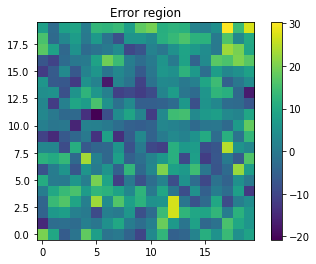

scaling factor for I/F: 1.1238390911125245e-06


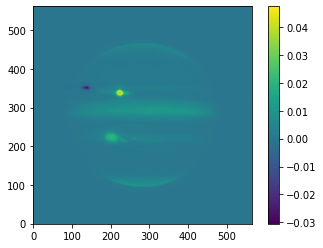

mu_0= 0.5 mu_1= 0.625


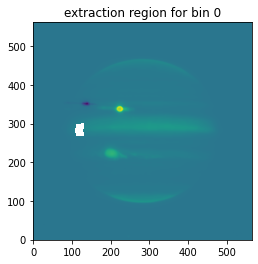

mu_0= 0.875 mu_1= 1.0


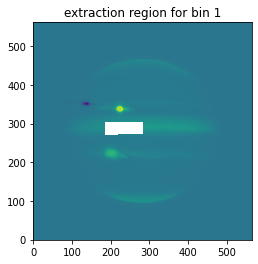

Extracting spectra for 2.16 microns...
Error estimate: 9.063313024346042


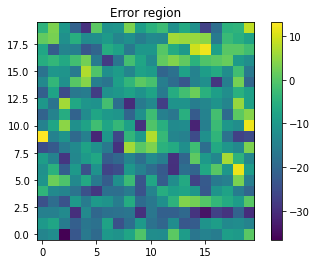

scaling factor for I/F: 2.320422114577572e-06


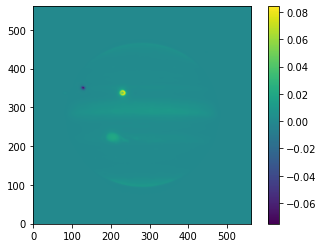

mu_0= 0.5 mu_1= 0.625


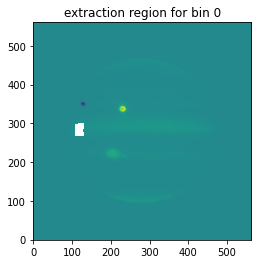

mu_0= 0.875 mu_1= 1.0


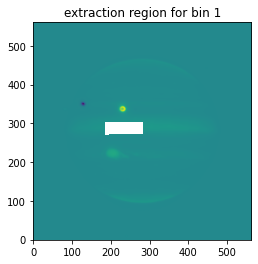

Extracting spectra for 2.26 microns...
Error estimate: 26.089314721969284


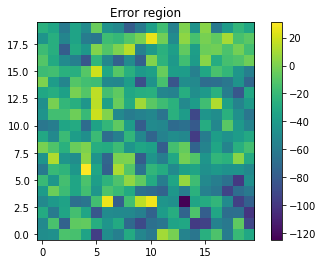

scaling factor for I/F: 3.9812161686992545e-07


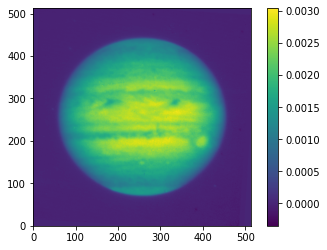

mu_0= 0.5 mu_1= 0.625


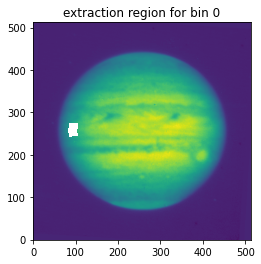

mu_0= 0.875 mu_1= 1.0


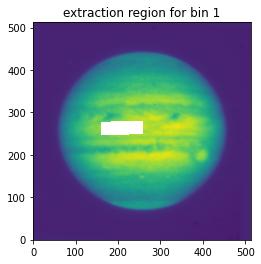

For .set file: distance between Sun and planet is 4.3004 AU
[array(7.24671e+25), array(6.26923e+25), array(2.62473e+25), array(2.46168e+25), array(2.10292e+25)]


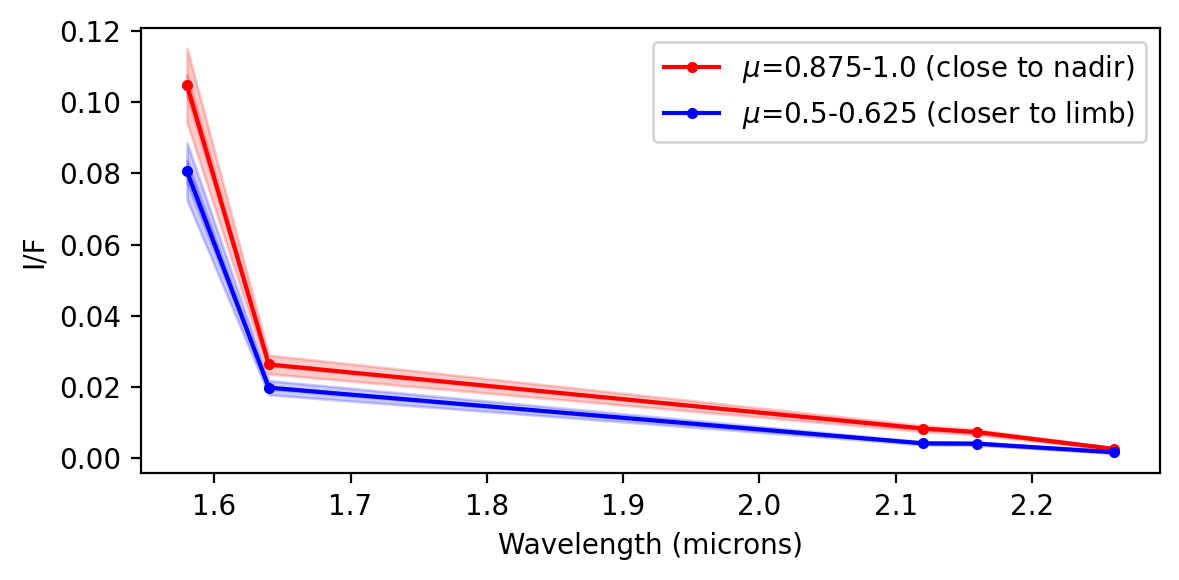

In [24]:
# example I ran locally, for debugging:
#spectrum_file_maker('/Users/emmadahl/Desktop/spextraction/spextraction_input_binned_lat.txt', \
#                    '/Users/emmadahl/Desktop/spextraction/irtf_data_march_2019/2019jun1/input_list', \
#                    '/Users/emmadahl/Desktop/spextraction/test_maps/', \
#                    '/Users/emmadahl/Desktop/irtf_spx_for_gattaca/jupiter.spx.2019jun1_v4_10percenterror',\
#                    '/Users/emmadahl/Desktop/spextraction/kurucz_HST_IRTF.dat', \
#                    wavelength_keyword='OSF', plot_maps=1, map_load=1, IF_scale=1, meancm_path='/Users/emmadahl/Desktop/spextraction/meancm/')